In [3]:
import cv2
import os
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D


In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()#train = 60.000, test = 10.000 Datensätze



In [5]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)



In [12]:

model = tf.keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))# - Zahlen auf 0 setzen
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))# 128 Neuronen, zwei Neuronen Layer, bei 3 war es schlechter, bei 1 auch schlechter. Accuracy mit 3 Layern = 0.9965
model.add(tf.keras.layers.Dense(10, activation='softmax')) #alle zusammen = 1 jedes neuron hat eine Zahl zwischen 0 und 1. Probality of each digit

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])
model.fit(x_train, y_train, epochs= 9) # 9 Epochen, bei 10 Epochen war eine schelchtere Accuracy, bis 9 ist die Accuracy besser geworden und die Loss weniger
model.save('handwritten.model')



Epoch 1/9
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1779 - accuracy: 0.9464
Epoch 2/9
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0649 - accuracy: 0.9800
Epoch 3/9
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0389 - accuracy: 0.9877
Epoch 4/9
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0275 - accuracy: 0.9912
Epoch 5/9
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0208 - accuracy: 0.9933
Epoch 6/9
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0157 - accuracy: 0.9946
Epoch 7/9
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0130 - accuracy: 0.9955
Epoch 8/9
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0115 - accuracy: 0.9960
Epoch 9/9
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0088 - accuracy: 0.9972


INFO:tensorflow:Assets written to: handwritten.model\assets


INFO:tensorflow:Assets written to: handwritten.model\assets


In [13]:
#Durchführen, falls das Model nicht erneuet trainiert werden soll, Lädt das bereits trainierte Modell neu ein
#model = tf.keras.models.load_model('handwritten.model') # Laden des Models
#loss, accuracy = model.evaluate(x_test, y_test)

In [34]:
#Erzeugen der Funktion, damit eine PNG mit 28x28 Größe die Zahl predicted werden kann.
def predicthandwritten(path): 
 img = cv2.imread(path)[:,:,0]
 img = np.invert(np.array([img]))
 prediction = model.predict(img)
 print(prediction)
 plt.imshow(img[0])
 plt.show()
 print("Die Vorhersage lautet: " , np.argmax(prediction) )
 



313/313 [==============================] - 2s 5ms/step
9


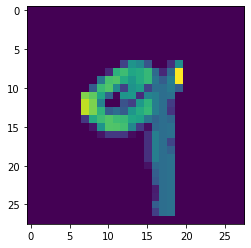

In [36]:
#Bild 322 des x_test predicten
predictions = model.predict(x_test)
print(np.argmax(predictions[322]))
plt.imshow(x_test[322])
plt.show()


1/1 [==============================] - 0s 26ms/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


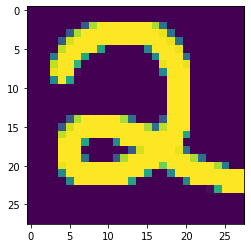

Die Vorhersage lautet:  2


In [37]:
#Bild mit dem Namen 7.png vorhersagen
predicthandwritten("2.png")

Text(69.0, 0.5, 'Tatsächlicher Wert')

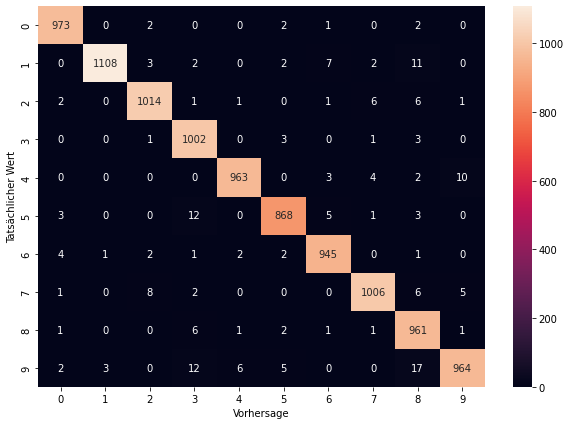

In [38]:
#Confusionsmatrix erstellen über den x_test Datensatz
prediction_labels = [np.argmax(i) for i in predictions]

confusionmatrix = tf.math.confusion_matrix(labels=y_test, predictions=prediction_labels)

plt.figure(figsize = (10, 7))
sn.heatmap(confusionmatrix, annot=True, fmt='d')
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächlicher Wert')